In [298]:
import pandas as pd
import pickle
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [282]:
file = open('./pickles/house_latlong.p','rb')
house_df = pickle.load(file)
real_estate_df = pickle.load(open('./pickles/real_estate_latlong.p','rb'))

In [283]:
#dropping NA values with lat long. 
house_df = house_df[~np.isnan(house_df.latitude)]
#redo this with the cosine(42) multiplication. 
house_df.loc[:,'e_long'] = house_df['longitude']*np.cos(np.radians(42))

#### Data Cleaning Notes:
Dropping following columns since they are Null/0 in more than 10% of the rows:  
- Alley
- PoolQC
- MiscFeature
- MiscVal (connected with MiscFeature)
- LowQualSF
- LandContour
- Electrical

Drop but potentially come back:   
- FireplaceQu
- MSZoning, MSSubClass
- MasVnrType, MasVnrArea
- LotFrontage

Drop since higly correlated:   
- Condition2 (same as condition1)
- Exterior2nd (same as Exterior1)
- ExterCond (similar to ExterQual)
- GarageCond (similear to GarageQual)

Drop ID/Address numbers:  
- MapRefNo
- PID
- Prop_Addr 

Drop due to linear dependence:   
- GrLivArea (sum of 1stflr, 2ndflr) NOTE SWITCHED
- TotalBsmtSF (sum of BsmtFinSF1, BsmtFinSF2, BsmtUnfSF) NOTE SWITCHED
 
Booleanize columns:   
- Fence 

Feature Combining:  
- Bathrooms: Sum of all bathrooms
- 

#### Feature Engineering Notes
Reengineer OverallQual/Cond columns (linear regression on other material/quality columns)

In [338]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2537 entries, 0 to 2623
Data columns (total 86 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PID            2537 non-null   int64  
 1   GrLivArea      2537 non-null   int64  
 2   SalePrice      2537 non-null   int64  
 3   MSSubClass     2537 non-null   int64  
 4   MSZoning       2537 non-null   object 
 5   LotFrontage    2083 non-null   float64
 6   LotArea        2537 non-null   int64  
 7   Street         2537 non-null   object 
 8   Alley          165 non-null    object 
 9   LotShape       2537 non-null   object 
 10  LandContour    2537 non-null   object 
 11  Utilities      2537 non-null   object 
 12  LotConfig      2537 non-null   object 
 13  LandSlope      2537 non-null   object 
 14  Neighborhood   2537 non-null   object 
 15  Condition1     2537 non-null   object 
 16  Condition2     2537 non-null   object 
 17  BldgType       2537 non-null   object 
 18  HouseSty

In [421]:
#columns to drop:
drop_columns = ['Alley','PoolQC','MiscFeature','MiscVal',
                'FireplaceQu','MSSubClass','MSZoning',
                'Condition2','PID','MapRefNo','Prop_Addr',
                'MasVnrType','MasVnrArea','BsmtFinSF1',
                'BsmtFinSF2','BsmtUnfSF','1stFlrSF','2ndFlrSF',
                'LowQualFinSF','ExterCond','Neighborhood','LotFrontage',
                'LotConfig','LotShape','LandContour','Exterior2nd',
                'GarageCond','Electrical','SaleType','SaleCondition',
                'Street','Utilities','RoofStyle','Functional','KitchenAbvGr']
#copied dataframe with dropped columns:
df = house_df.drop(drop_columns,axis = 1)

##feature relations:
#bathrooms
df['bathrooms'] = df['FullBath'] + df['BsmtFullBath'] + 0.5*(df['BsmtHalfBath'] + df['HalfBath'])
df = df.drop(['FullBath','BsmtFullBath','BsmtHalfBath','HalfBath','bathrooms'],axis = 1) #dropped bathroom because its not in real_estate_df
df2 = df.copy()
#Age
df['Age'] = df['YrSold'] - df['YearRemodAdd']
df['WasRemodeled'] = (df.YearRemodAdd != df.YearBuilt).astype(np.int64)
df = df.drop(['YrSold','YearRemodAdd','YearBuilt'],axis = 1)
#Fence
df.loc[:,'Fence'] = (~df.Fence.isna()).astype(np.int64)
#Basement
df = df.drop(['BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2'], axis = 1)
df['BsmtQual'][df['BsmtQual'].isna()] = 'TA'
#Garage
df['HasGarage'] = df.GarageArea.apply(lambda x: 1 if x > 0 else 0).astype(np.int64)
df = df.drop([col for col in list(df.columns) if 'Garage' in col],axis = 1)

#Dummify
df = pd.get_dummies(df,drop_first=True)

#Last nulls set to 0
df[np.isnan(df)] = 0 

#Log of the SalePrice
#df.loc[:,'SalePrice'] = np.log(df['SalePrice'])

<ipython-input-421-994c6535c321>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BsmtQual'][df['BsmtQual'].isna()] = 'TA'


In [359]:
KNR = KNeighborsRegressor()

x_train, x_test, y_train, y_test = train_test_split(df.drop('SalePrice', axis = 1),
                                                    df['SalePrice'], test_size = .2,
                                                    random_state = 42)
params = {'n_neighbors':range(10,100)}
gcv_knr = GridSearchCV(KNR,param_grid = params)

gcv_knr.fit(x_train[['latitude','e_long']],y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': range(10, 100)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [360]:
gcv_knr.score(x_train[['latitude','e_long']],y_train), gcv_knr.score(x_test[['latitude','e_long']],y_test)

(0.761270677624868, 0.6697964124020531)

In [357]:
KNR = KNeighborsRegressor()



x_train_pf, x_test_pf, y_train_pf, y_test_pf = train_test_split(df.drop('SalePrice', axis = 1),
                                                    df['SalePrice']/(df['GrLivArea']),
                                                    test_size = .2,
                                                    random_state = 42)

params = {'n_neighbors':range(10,100)}
gcv_knr_price_foot = GridSearchCV(KNR,param_grid = params)

gcv_knr_price_foot.fit(x_train_pf[['latitude','e_long']],y_train_pf)

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': range(10, 100)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [358]:
gcv_knr_price_foot.score(x_train_pf[['latitude','e_long']],y_train_pf), gcv_knr_price_foot.score(x_test_pf[['latitude','e_long']],y_test_pf)

(0.49475991521041096, 0.3616953414330165)

In [361]:
lam = .3
x_train.loc[:,'residuals'] = y_train - lam*gcv_knr.predict(x_train[['latitude','e_long']])
x_test.loc[:,'residuals'] = y_test - lam*gcv_knr.predict(x_test[['latitude','e_long']])

x_train = x_train.drop(['latitude','longitude','e_long'],axis = 1)
x_test = x_test.drop(['latitude','longitude','e_long'], axis =1)

In [362]:
lm_ridge = Ridge()
lmr_gcv = GridSearchCV(lm_ridge,param_grid={'alpha':[1,5,10]})
final_model = make_pipeline(StandardScaler(),lmr_gcv)
final_model.fit(x_train.drop('residuals', axis =1), x_train['residuals'])

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('gridsearchcv',
                 GridSearchCV(cv=None, error_score=nan,
                              estimator=Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=None,
                                              normalize=False,
                                              random_state=None, solver='auto',
                                              tol=0.001),
                              iid='deprecated', n_jobs=None,
                              param_grid={'alpha': [1, 5, 10]},
                              pre_dispatch='2*n_jobs', refit=True,
                              return_train_score=False, scoring=None,
                              verbose=0))],
         verbose=False)

In [363]:
final_model.score(x_train.drop('residuals', axis =1), x_train['residuals']), final_model.score(x_test.drop('residuals', axis =1), x_test['residuals'])

(0.8789120283347548, 0.8527876168538928)

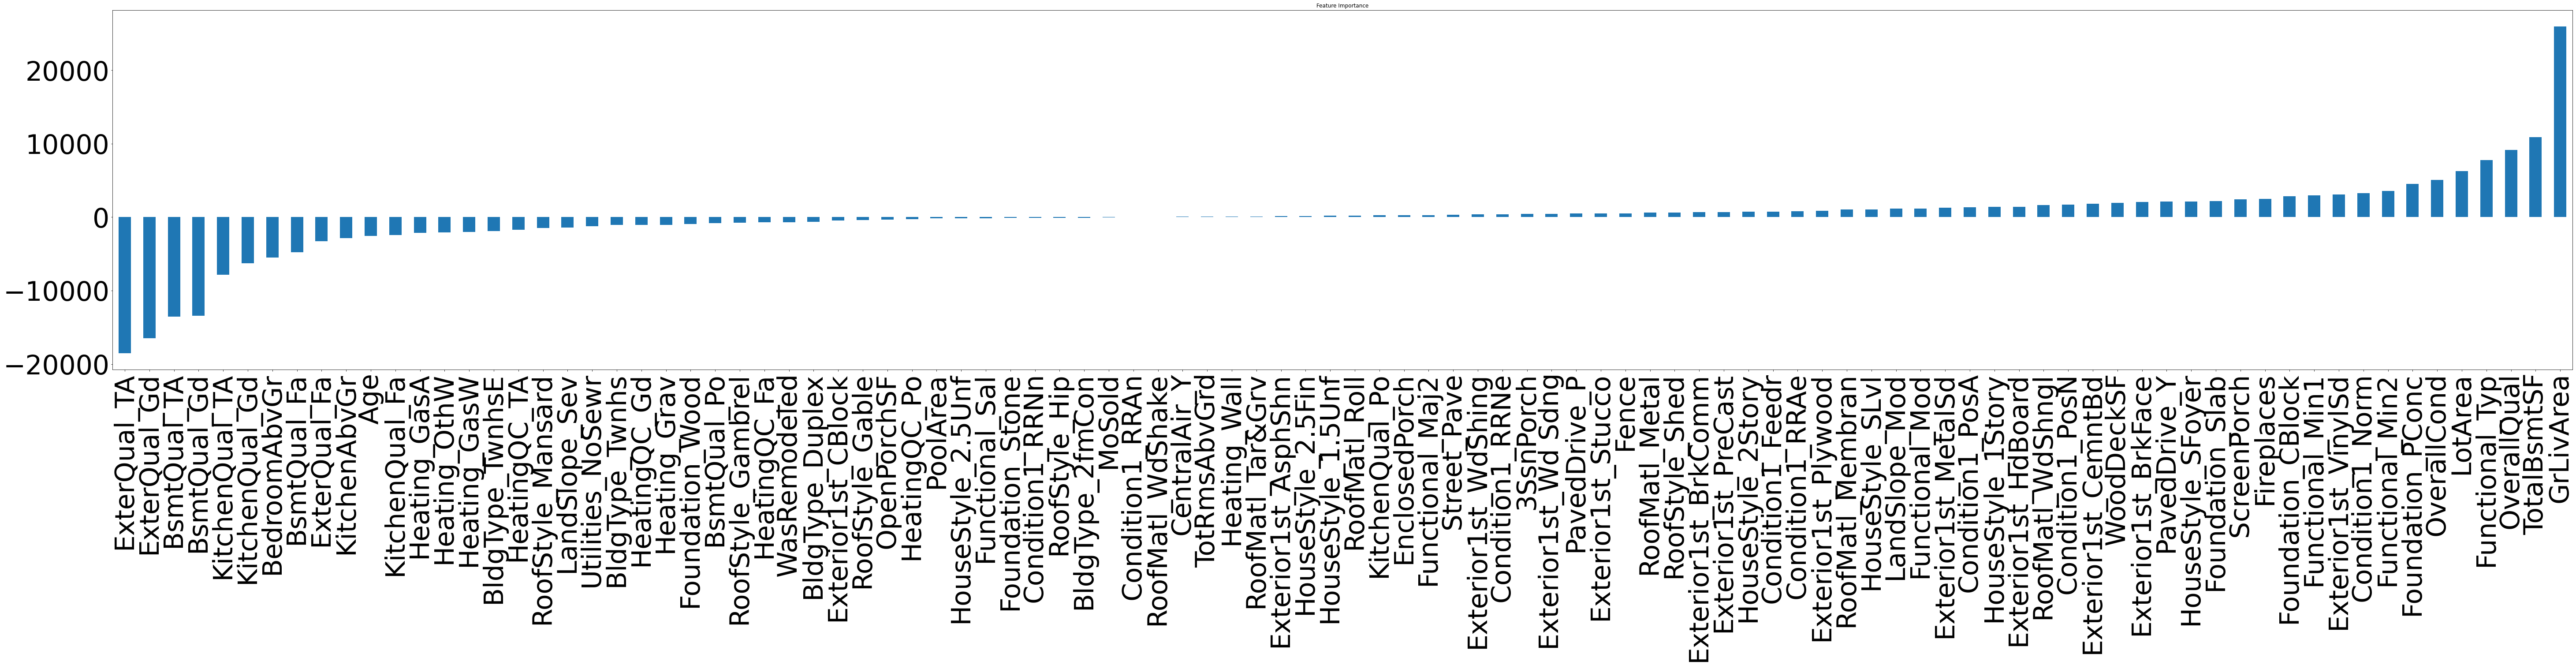

In [364]:
pd.Series(dict(zip(x_train.drop('residuals', axis =1).columns, final_model.named_steps.gridsearchcv.best_estimator_.coef_))).sort_values().plot.bar(rot = 90, figsize = (100,15),fontsize = 60, title = 'Feature Importance')

### How Do We Make Money

We want to use the real_estate dataset to identify houses to buy and estimate potential value per house. 



In [422]:
real_estate_df = real_estate_df.rename(columns = {'GLA':'GrLivArea',
                                                  'YrSold_YYYY':'YrSold',
                                                  'MoSold_MM':'MoSold',
                                                  'Ext1':'Exterior1st',
                                                  'TtlBsmtSF':'TotalBsmtSF',
                                                  'YrBuilt':'YearBuilt',
                                                  'GarYrBlt':'GarageYrBlt',
                                                  'Cars':'GarageCars',
                                                  'Central Air':'CentralAir',
                                                  'NmbrBRs':'BedroomAbvGr'})

In [409]:
def column_match(list1,list2):
    '''
    Inputs two columns of strings and outputs list of matching strings, 
    list of strings in list1 but not 2 and list of strings in list2 but not 1
    '''
    match_list = []
    diff_list = []
    
    for el in list1:
        if el in list2:
            match_list.append(el)
            list2.remove(el)
        else:
            diff_list.append(el)
    return(match_list,diff_list, list2)

In [423]:
col1, col2, col3 = column_match(list(df2.columns),list(real_estate_df.columns))

In [424]:
col1, col2, col3

(['GrLivArea',
  'SalePrice',
  'LotArea',
  'BldgType',
  'HouseStyle',
  'YearBuilt',
  'RoofMatl',
  'Exterior1st',
  'Foundation',
  'TotalBsmtSF',
  'Heating',
  'CentralAir',
  'BedroomAbvGr',
  'TotRmsAbvGrd',
  'Fireplaces',
  'GarageType',
  'GarageYrBlt',
  'GarageCars',
  'GarageArea',
  'PoolArea',
  'MoSold',
  'YrSold',
  'latitude',
  'longitude'],
 ['LandSlope',
  'Condition1',
  'OverallQual',
  'OverallCond',
  'YearRemodAdd',
  'ExterQual',
  'BsmtQual',
  'BsmtCond',
  'BsmtExposure',
  'BsmtFinType1',
  'BsmtFinType2',
  'HeatingQC',
  'KitchenQual',
  'GarageFinish',
  'GarageQual',
  'PavedDrive',
  'WoodDeckSF',
  'OpenPorchSF',
  'EnclosedPorch',
  '3SsnPorch',
  'ScreenPorch',
  'Fence',
  'e_long'],
 ['MapRefNo',
  'GeoRefNo',
  'Tier',
  'Range',
  'Prop_Addr',
  'ZngCdPr',
  'ZngCdSc',
  'ZngOLPr',
  'ZngOLSc',
  'ClassPr_S',
  'ClassSc_S',
  'Legal_Pr',
  'SchD_S',
  'TxD_S',
  'MA_Ownr1',
  'MA_Ownr2',
  'MA_Line1',
  'MA_Line2',
  'MA_City',
  'MA_State'

In [407]:
real_estate_df[col3].head()

,MapRefNo,GeoRefNo,Tier,Range,Prop_Addr,ZngCdPr,ZngCdSc,ZngOLPr,ZngOLSc,ClassPr_S,...,PA-Nmbr,PA-PreD,PA-Strt,PA-StSfx,PA-PostD,PA-UnTyp,PA-UntNo,Date,Source,NmbrBRs
112,526350030,526350030,0,0,3111 GROVE AVE,RH,NaN,NaN,NaN,RESIDENTIAL,...,3111,NaN,GROVE,AVE,NaN,NaN,NaN,10-Jul-20,Ames City Assessor,3.0
113,526350040,526350040,0,0,3109 GROVE AVE,RH,NaN,NaN,NaN,RESIDENTIAL,...,3109,NaN,GROVE,AVE,NaN,NaN,NaN,10-Jul-20,Ames City Assessor,2.0
114,526350050,526350050,0,0,3017 GROVE AVE,RH,NaN,NaN,NaN,RESIDENTIAL,...,3017,NaN,GROVE,AVE,NaN,NaN,NaN,10-Jul-20,Ames City Assessor,5.0
115,526350060,526350060,0,0,3013 GROVE AVE,RH,NaN,NaN,NaN,RESIDENTIAL,...,3013,NaN,GROVE,AVE,NaN,NaN,NaN,10-Jul-20,Ames City Assessor,4.0
118,526351010,526351010,0,0,630 RIVER OAK DR,RL,NaN,NaN,NaN,RESIDENTIAL,...,630,NaN,RIVER OAK,DR,NaN,NaN,NaN,10-Jul-20,Ames City Assessor,3.0


In [335]:
real_estate_df = real_estate_df[~real_estate_df['latitude'].isna()]
real_estate_df = real_estate_df[~real_estate_df['GLA'].isna()]
real_estate_df

,MapRefNo,GeoRefNo,Tier,Range,Prop_Addr,ZngCdPr,ZngCdSc,ZngOLPr,ZngOLSc,ClassPr_S,...,PA-Strt,PA-StSfx,PA-PostD,PA-UnTyp,PA-UntNo,Date,Source,NmbrBRs,latitude,longitude
112,526350030,526350030,0,0,3111 GROVE AVE,RH,NaN,NaN,NaN,RESIDENTIAL,...,GROVE,AVE,NaN,NaN,NaN,10-Jul-20,Ames City Assessor,3.0,42.053053,-93.619794
113,526350040,526350040,0,0,3109 GROVE AVE,RH,NaN,NaN,NaN,RESIDENTIAL,...,GROVE,AVE,NaN,NaN,NaN,10-Jul-20,Ames City Assessor,2.0,42.052806,-93.619783
114,526350050,526350050,0,0,3017 GROVE AVE,RH,NaN,NaN,NaN,RESIDENTIAL,...,GROVE,AVE,NaN,NaN,NaN,10-Jul-20,Ames City Assessor,5.0,42.051556,-93.619747
115,526350060,526350060,0,0,3013 GROVE AVE,RH,NaN,NaN,NaN,RESIDENTIAL,...,GROVE,AVE,NaN,NaN,NaN,10-Jul-20,Ames City Assessor,4.0,42.051502,-93.619747
118,526351010,526351010,0,0,630 RIVER OAK DR,RL,NaN,NaN,NaN,RESIDENTIAL,...,RIVER OAK,DR,NaN,NaN,NaN,10-Jul-20,Ames City Assessor,3.0,42.052700,-93.618833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22101,923275180,923275180,0,0,3819 MINNETONKA AVE,RL,NaN,NaN,NaN,RESIDENTIAL,...,MINNETONKA,AVE,NaN,NaN,NaN,10-Jul-20,Ames City Assessor,3.0,41.988231,-93.604250
22102,923275190,923275190,0,0,3823 MINNETONKA AVE,RL,NaN,NaN,NaN,RESIDENTIAL,...,MINNETONKA,AVE,NaN,NaN,NaN,10-Jul-20,Ames City Assessor,3.0,41.988232,-93.604304
22103,923275200,923275200,0,0,3827 MINNETONKA AVE,RL,NaN,NaN,NaN,RESIDENTIAL,...,MINNETONKA,AVE,NaN,NaN,NaN,10-Jul-20,Ames City Assessor,2.0,41.988232,-93.604358
22104,923276010,923276010,0,0,605 GARDEN RD,RL,NaN,NaN,NaN,RESIDENTIAL,...,GARDEN,RD,NaN,NaN,NaN,10-Jul-20,Ames City Assessor,3.0,41.989124,-93.604086


In [336]:
real_estate_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11689 entries, 112 to 22105
Data columns (total 93 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MapRefNo      11689 non-null  int64  
 1   GeoRefNo      11689 non-null  int64  
 2   Tier          11689 non-null  int64  
 3   Range         11689 non-null  int64  
 4   Prop_Addr     11689 non-null  object 
 5   ZngCdPr       11689 non-null  object 
 6   ZngCdSc       11 non-null     object 
 7   ZngOLPr       664 non-null    object 
 8   ZngOLSc       123 non-null    object 
 9   ClassPr_S     11689 non-null  object 
 10  ClassSc_S     11689 non-null  object 
 11  Legal_Pr      11689 non-null  object 
 12  SchD_S        11689 non-null  int64  
 13  TxD_S         11689 non-null  int64  
 14  MA_Ownr1      11689 non-null  object 
 15  MA_Ownr2      2357 non-null   object 
 16  MA_Line1      11675 non-null  object 
 17  MA_Line2      0 non-null      float64
 18  MA_City       11675 non-